In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
import scipy
import time
import collections
import itertools
import librosa
import pickle

# Extract Features from Wave Files

In [2]:
#directory to training data and json file
train_dir4='/home/aka/Documents/nsynth-train/audio/'
#directory to training data and json file
valid_dir4='/home/aka/Documents/nsynth-valid/audio/'
#directory to training data and json file
test_dir4='/home/aka/Documents/nsynth-test/audio/'

- Number of Zero Crossings
- max mean mfcc
- centroid mean
- centroid std
- centroid skewness
- max mean contrast
- rolloff mean
- rolloff std
- rolloff skewness
- zero crossing rate mean
- zero crossing rate std
- zero crossing rate skewness

In [3]:
#read the raw json files as given in the training set
df_train_raw4 = pd.read_json(path_or_buf='nsynth-train/examples.json', orient='index')

In [4]:
#Get a count of instruments in ascending order
n_class_train4 = df_train_raw4['instrument_family'].value_counts(ascending=True)
n_class_train4

9      5501
2      8773
10    10208
1     12675
7     13911
8     19474
3     32690
5     34201
6     34477
4     51821
0     65474
Name: instrument_family, dtype: int64

In [5]:
#Sample n files
df_train_sample4=df_train_raw4.groupby('instrument_family', as_index=False, #group by instrument family
                               group_keys=False).apply(lambda df: df.sample(1000)) #number of samples
#drop the synth_lead from the training dataset
df_train_sample4= df_train_sample4[df_train_sample4['instrument_family']!=9]
df_train_sample4= df_train_sample4[df_train_sample4['instrument_family']!=7]
df_train_sample4= df_train_sample4[df_train_sample4['instrument_family']!=4]

In [6]:
df_train_sample4.head()

,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,instrument_family,instrument,qualities
bass_synthetic_075-066-127,217006,16000,66,2,bass,bass_synthetic_075,bass_synthetic_075-066-127,"[fast_decay, percussive]",synthetic,127,0,678,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 0]"
bass_synthetic_001-039-100,187449,16000,39,2,bass,bass_synthetic_001,bass_synthetic_001-039-100,"[bright, distortion, tempo-synced]",synthetic,100,0,14,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 1]"
bass_synthetic_021-063-100,187735,16000,63,2,bass,bass_synthetic_021,bass_synthetic_021-063-100,[],synthetic,100,0,317,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
bass_synthetic_032-086-100,225035,16000,86,2,bass,bass_synthetic_032,bass_synthetic_032-086-100,[],synthetic,100,0,408,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
bass_synthetic_008-083-100,194511,16000,83,2,bass,bass_synthetic_008,bass_synthetic_008-083-100,[],synthetic,100,0,134,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [7]:
print(df_train_sample4.shape)

(8000, 13)


In [8]:
print(df_train_sample4["instrument_family_str"].unique())

['bass' 'brass' 'flute' 'guitar' 'mallet' 'organ' 'string' 'vocal']


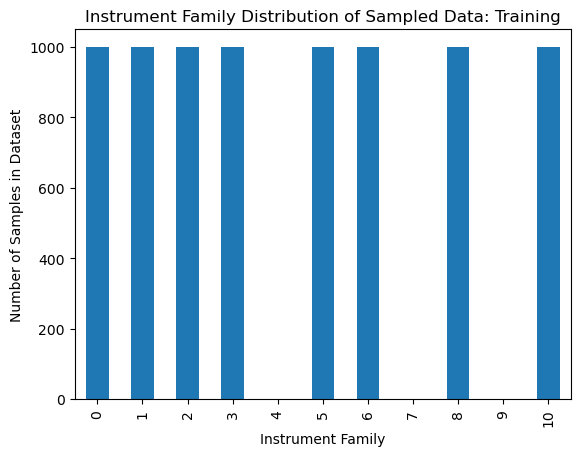

In [9]:
#Display instrument distrution
df_train_sample4['instrument_family'].value_counts().reindex(np.arange(0,len(n_class_train4), 1)).plot(kind='bar')
plt.title("Instrument Family Distribution of Sampled Data: Training")
plt.xlabel('Instrument Family')
plt.ylabel('Number of Samples in Dataset')
plt.show()

In [10]:
#save the train file index as list
filenames_train4 = df_train_sample4.index.tolist()

In [11]:
#save the list to a pickle file
with open('DataWrangling/filenames_train_kb.pickle', 'wb') as f:
    pickle.dump(filenames_train4, f)

In [12]:
#extract the filenames from the validation dataset
df_valid_raw4 = pd.read_json(path_or_buf='nsynth-valid/examples.json', orient='index')

#Sample n files
df_valid4=df_valid_raw4.groupby('instrument_family', as_index=False, #group by instrument family
                               group_keys=False).apply(lambda df: df.sample(240)) #number of samples
#drop the synth_lead from the training dataset
df_valid4= df_valid4[df_valid4['instrument_family']!=9]
df_valid4= df_valid4[df_valid4['instrument_family']!=7]
df_valid4= df_valid4[df_valid4['instrument_family']!=4]


print(df_valid4["instrument_family_str"].unique())
df_valid4.head()

['bass' 'brass' 'flute' 'guitar' 'mallet' 'organ' 'string' 'vocal']


,note_str,sample_rate,qualities_str,instrument_source,instrument_family_str,instrument_family,note,instrument_source_str,qualities,pitch,instrument_str,instrument,velocity
bass_electronic_018-025-100,bass_electronic_018-025-100,16000,[],1,bass,0,105368,electronic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",25,bass_electronic_018,759,100
bass_synthetic_033-090-127,bass_synthetic_033-090-127,16000,[],2,bass,0,177573,synthetic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",90,bass_synthetic_033,417,127
bass_synthetic_068-061-025,bass_synthetic_068-061-025,16000,[dark],2,bass,0,219631,synthetic,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",61,bass_synthetic_068,656,25
bass_synthetic_135-059-100,bass_synthetic_135-059-100,16000,[distortion],2,bass,0,197904,synthetic,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",59,bass_synthetic_135,927,100
bass_synthetic_135-027-025,bass_synthetic_135-027-025,16000,[distortion],2,bass,0,266793,synthetic,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",27,bass_synthetic_135,927,25


In [13]:
#save the train file index as list
filenames_valid4 = df_valid4.index.tolist()

#save the list to a pickle file
with open('DataWrangling/filenames_valid_kb.pickle', 'wb') as f:
    pickle.dump(filenames_valid4, f)

In [14]:
df_valid4.shape

(1920, 13)

In [15]:
#extract the filenames from the testing dataset

df_test_raw4 = pd.read_json(path_or_buf='nsynth-test/examples.json', orient='index')

#Sample n files
df_test4=df_test_raw4.groupby('instrument_family', as_index=False, #group by instrument family
                               group_keys=False).apply(lambda df: df.sample(80)) #number of samples
#drop the synth_lead from the training dataset
df_test4= df_test4[df_test4['instrument_family']!=9]
df_test4= df_test4[df_test4['instrument_family']!=7]
df_test4= df_test4[df_test4['instrument_family']!=4]

print(df_test4["instrument_family_str"].unique())
df_test4.head()

['bass' 'brass' 'flute' 'guitar' 'mallet' 'organ' 'string' 'vocal']


,qualities,pitch,note,instrument_source_str,velocity,instrument_str,instrument,sample_rate,qualities_str,instrument_source,note_str,instrument_family,instrument_family_str
bass_synthetic_009-081-025,"[1, 0, 1, 0, 1, 0, 0, 0, 0, 0]",81,281416,synthetic,25,bass_synthetic_009,150,16000,"[bright, distortion, long_release]",2,bass_synthetic_009-081-025,0,bass
bass_synthetic_134-083-100,"[0, 0, 0, 1, 0, 0, 0, 1, 1, 0]",83,269261,synthetic,100,bass_synthetic_134,914,16000,"[fast_decay, percussive, reverb]",2,bass_synthetic_134-083-100,0,bass
bass_synthetic_009-068-127,"[1, 0, 1, 0, 1, 0, 0, 0, 0, 0]",68,238355,synthetic,127,bass_synthetic_009,150,16000,"[bright, distortion, long_release]",2,bass_synthetic_009-068-127,0,bass
bass_synthetic_135-095-100,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",95,45806,synthetic,100,bass_synthetic_135,927,16000,[distortion],2,bass_synthetic_135-095-100,0,bass
bass_synthetic_068-108-050,"[1, 0, 0, 1, 0, 0, 0, 1, 0, 0]",108,241249,synthetic,50,bass_synthetic_068,656,16000,"[bright, fast_decay, percussive]",2,bass_synthetic_068-108-050,0,bass


In [16]:
df_test4.shape

(640, 13)

In [17]:
#save the train file index as list
filenames_test4 = df_test4.index.tolist()

#save the list to a pickle file
with open('DataWrangling/filenames_test_kb.pickle', 'wb') as f:
    pickle.dump(filenames_test4, f)

In [18]:
def feature_extract4(file):
    """
    Define function that takes in a file an returns features in an array
    """
    
    #get wave representation
    y, sr = librosa.load(file)
        
    #determine if instruemnt is harmonic or percussive by comparing means
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    if np.mean(y_harmonic)>np.mean(y_percussive):
        harmonic=1
    else:
        harmonic=0
        
    #Mel-frequency cepstral coefficients (MFCCs)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=14)
    #temporal averaging
    mfcc=np.mean(mfcc,axis=1)
    
    #get the mel-scaled spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=148,fmax=8000)  
    #temporally average spectrogram
    spectrogram = np.mean(spectrogram, axis = 1)
    
    #compute chroma energy
    chroma = librosa.feature.chroma_cens(y=y, sr=sr)
    #temporally average chroma
    chroma = np.mean(chroma, axis = 1)
    
    #compute spectral contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    contrast = np.mean(contrast, axis= 1)
    
    return [harmonic, mfcc, spectrogram, chroma, contrast]

In [19]:
def instrument_code4(filename):
    """
    Function that takes in a filename and returns instrument based on naming convention
    """
    class_names=['bass', 'brass', 'flute', 
                 'guitar','organ', 'reed', 
             'string', 'synth_lead', 'vocal']
    
    for name in class_names:
        if name in filename:
            return class_names.index(name)
    else:
        return None

The function above can take a lot of time for large datasets. It is advisisable to start out on small samples to get an estimate of running time.

## Testing Set

In [20]:
#create dictionary to store all test features
dict_test4 = {}
#loop over every file in the list
for file4 in filenames_test4:
    #extract the features
    features4 = feature_extract4(test_dir4+ file4 + '.wav') #specify directory and .wav
    #add dictionary entry
    dict_test4[file4] = features4

/home/aka/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


In [21]:
#convert dict to dataframe
features_test4 = pd.DataFrame.from_dict(dict_test4, orient='index',
                                       columns=['harmonic', 'mfcc', 'spectro', 'chroma', 'contrast'])

features_test4.head()

,harmonic,mfcc,spectro,chroma,contrast
bass_synthetic_033-048-025,1,"[-438.17865, 71.60791, 58.217854, 40.95569, 24...","[24.368471, 0.026223475, 0.028260833, 0.038059...","[0.8259909, 0.36032718, 0.059890565, 0.0315331...","[33.09106453191202, 29.50218105581526, 36.5770..."
bass_synthetic_098-087-025,0,"[-555.92316, 50.874107, 39.864758, 34.287315, ...","[200.3146, 6.398643, 4.1230435, 1.688514, 1.26...","[0.36718825, 0.37921923, 0.32294562, 0.2789201...","[29.389536162834627, 16.418658428124164, 17.30..."
bass_electronic_018-041-050,0,"[-487.2165, 86.86398, 68.62828, 52.285748, 37....","[0.9401278, 0.8408023, 4.915442, 59.888916, 31...","[0.5025899, 0.039744783, 0.052600354, 0.073792...","[29.667581080852813, 24.16697913475579, 24.659..."
bass_electronic_025-032-075,0,"[-461.7434, 52.40346, 47.500557, 45.281574, 40...","[0.22202866, 177.20114, 210.32199, 79.35899, 5...","[0.003927067, 0.0, 0.0, 0.009444809, 0.0090435...","[27.437347418835085, 25.22522153976387, 20.876..."
bass_synthetic_033-030-050,0,"[-461.0561, 77.141785, 70.10777, 59.74938, 47....","[16.269249, 321.71402, 150.71135, 66.97469, 84...","[0.010512343, 0.33310077, 0.011624486, 0.01925...","[19.828221420715277, 23.533140652796252, 24.75..."


In [22]:
#extract mfccs
mfcc_test4 = pd.DataFrame(features_test4.mfcc.values.tolist(),index=features_test4.index)
mfcc_test4 = mfcc_test4.add_prefix('mfcc_')

#extract spectro
spectro_test4 = pd.DataFrame(features_test4.spectro.values.tolist(),index=features_test4.index)
spectro_test4 = spectro_test4.add_prefix('spectro_')


#extract chroma
chroma_test4 = pd.DataFrame(features_test4.chroma.values.tolist(),index=features_test4.index)
chroma_test4 = chroma_test4.add_prefix('chroma_')


#extract contrast
contrast_test4 = pd.DataFrame(features_test4.contrast.values.tolist(),index=features_test4.index)
contrast_test4 = chroma_test4.add_prefix('contrast_')

#drop the old columns
features_test4 = features_test4.drop(labels=['mfcc', 'spectro', 'chroma', 'contrast'], axis=1)

#concatenate
df_features_test4=pd.concat([features_test4, mfcc_test4, spectro_test4, chroma_test4, contrast_test4],
                           axis=1, join='inner')
df_features_test4.head()

,harmonic,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,contrast_chroma_2,contrast_chroma_3,contrast_chroma_4,contrast_chroma_5,contrast_chroma_6,contrast_chroma_7,contrast_chroma_8,contrast_chroma_9,contrast_chroma_10,contrast_chroma_11
bass_synthetic_033-048-025,1,-438.178650,71.607910,58.217854,40.955688,24.736628,12.813897,5.880034,2.619494,1.052201,...,0.059891,0.031533,0.032734,0.023594,0.039088,0.022063,0.043137,0.049210,0.037647,0.139275
bass_synthetic_098-087-025,0,-555.923157,50.874107,39.864758,34.287315,31.961660,29.768579,27.211401,23.670527,20.167419,...,0.322946,0.278920,0.271300,0.243733,0.290458,0.253115,0.252768,0.221153,0.177150,0.129004
bass_electronic_018-041-050,0,-487.216492,86.863983,68.628281,52.285748,37.300919,23.525389,12.262171,3.197381,-3.443352,...,0.052600,0.073792,0.118656,0.699086,0.096640,0.045692,0.046418,0.065768,0.049174,0.064092
bass_electronic_025-032-075,0,-461.743408,52.403461,47.500557,45.281574,40.763142,35.705200,31.699780,27.053719,22.536587,...,0.000000,0.009445,0.009044,0.018067,0.054006,0.159346,0.836835,0.347058,0.072493,0.035956
bass_synthetic_033-030-050,0,-461.056091,77.141785,70.107773,59.749378,47.722881,35.709435,25.050844,16.538420,10.387195,...,0.011624,0.019251,0.079591,0.211009,0.775182,0.170313,0.032141,0.012632,0.000000,0.000000


In [23]:
targets_test4 = []
for name4 in df_features_test4.index.tolist():
    targets_test4.append(instrument_code4(name4))

df_features_test4['targets'] = targets_test4

In [24]:
#save the dataframe to a pickle file
with open('DataWrangling/df_features_test_kb.pickle', 'wb') as f:
    pickle.dump(df_features_test4, f)

In [25]:
df_features_test4.shape

(640, 188)

## Traning Set

In [26]:
start_train4 = time.time()

#create dictionary to store all test features
dict_train4 = {}
#loop over every file in the list
for file4 in filenames_train4:
    #extract the features
    features4 = feature_extract4(train_dir4 + file4 + '.wav') #specify directory and .wav
    #add dictionary entry
    dict_train4[file4] = features4

end_train4 = time.time()
print('Time to extract {} files is {} seconds'.format(len(filenames_train4), end_train4 - start_train4))

/home/aka/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


Time to extract 8000 files is 4553.444787740707 seconds


In [27]:
#convert dict to dataframe
features_train4 = pd.DataFrame.from_dict(dict_train4, orient='index',
                                       columns=['harmonic', 'mfcc', 'spectro', 'chroma', 'contrast'])

features_train4.head()

,harmonic,mfcc,spectro,chroma,contrast
bass_synthetic_141-041-050,1,"[-409.1168, 69.53101, 56.37672, 42.255375, 31....","[0.19533485, 0.4393917, 332.63052, 5564.2603, ...","[0.11118278, 0.050115816, 0.050096348, 0.08484...","[31.86419276730357, 29.85684790556911, 28.3085..."
bass_electronic_021-051-100,0,"[-511.71725, 36.044266, 24.325424, 18.754953, ...","[0.31557888, 0.16022964, 0.16636316, 0.2379083...","[0.09421155, 0.11478075, 0.13956936, 0.8499632...","[29.47011027175367, 21.208741021168287, 23.550..."
bass_synthetic_080-070-075,1,"[-495.12173, 17.697426, 3.9971914, -2.6757724,...","[0.17603107, 0.13763948, 0.037403654, 0.021442...","[0.13318379, 0.17586057, 0.1359803, 0.1291888,...","[21.591749946705615, 19.626282157936572, 31.25..."
bass_synthetic_085-098-127,1,"[-355.37595, -28.508917, -35.36893, 57.1536, -...","[270.81326, 1.0955265, 0.3659032, 0.19867907, ...","[0.12747513, 0.14137483, 0.7646104, 0.09316051...","[41.10472302076148, 24.508551918263038, 35.941..."
bass_electronic_016-058-025,1,"[-505.16736, 26.149422, 17.506334, 15.978201, ...","[0.016378189, 0.09826441, 0.6635479, 1.3088259...","[0.07757746, 0.10771125, 0.22182478, 0.0990107...","[22.38270193751639, 29.449961578934847, 20.513..."


In [28]:
#extract mfccs
mfcc_train4 = pd.DataFrame(features_train4.mfcc.values.tolist(),
                          index=features_train4.index)
mfcc_train4 = mfcc_train4.add_prefix('mfcc_')

#extract spectro
spectro_train4 = pd.DataFrame(features_train4.spectro.values.tolist(),
                             index=features_train4.index)
spectro_train4 = spectro_train4.add_prefix('spectro_')


#extract chroma
chroma_train4 = pd.DataFrame(features_train4.chroma.values.tolist(),
                            index=features_train4.index)
chroma_train4 = chroma_train4.add_prefix('chroma_')


#extract contrast
contrast_train4 = pd.DataFrame(features_train4.contrast.values.tolist(),
                              index=features_train4.index)
contrast_train4 = chroma_train4.add_prefix('contrast_')

#drop the old columns
features_train4 = features_train4.drop(labels=['mfcc', 'spectro', 'chroma', 'contrast'], axis=1)

#concatenate
df_features_train4=pd.concat([features_train4, mfcc_train4, spectro_train4, chroma_train4, contrast_train4],
                           axis=1, join='inner')
df_features_train4.head()

,harmonic,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,contrast_chroma_2,contrast_chroma_3,contrast_chroma_4,contrast_chroma_5,contrast_chroma_6,contrast_chroma_7,contrast_chroma_8,contrast_chroma_9,contrast_chroma_10,contrast_chroma_11
bass_synthetic_141-041-050,1,-409.116791,69.531013,56.376720,42.255375,31.553745,24.275185,18.532675,13.423857,9.344967,...,0.050096,0.084849,0.175900,0.819804,0.144161,0.070890,0.038794,0.052259,0.023774,0.060006
bass_electronic_021-051-100,0,-511.717255,36.044266,24.325424,18.754953,14.956080,10.883185,6.117507,1.279071,-1.339385,...,0.139569,0.849963,0.075981,0.046074,0.038909,0.048514,0.038605,0.044220,0.081513,0.061887
bass_synthetic_080-070-075,1,-495.121735,17.697426,3.997191,-2.675772,-5.213784,-5.764309,-5.587150,-5.792887,-5.970635,...,0.135980,0.129189,0.131936,0.127206,0.168562,0.116394,0.044884,0.229673,0.521629,0.264406
bass_synthetic_085-098-127,1,-355.375946,-28.508917,-35.368931,57.153599,-22.826521,10.271304,-38.730553,6.995968,12.586042,...,0.764610,0.093161,0.217482,0.154719,0.051625,0.078636,0.320729,0.019313,0.002233,0.135237
bass_electronic_016-058-025,1,-505.167358,26.149422,17.506334,15.978201,11.623926,7.589797,3.944977,1.205248,-1.366086,...,0.221825,0.099011,0.075137,0.088636,0.114205,0.094625,0.088856,0.117913,0.778585,0.126127


In [29]:
targets_train4 = []
for name4 in df_features_train4.index.tolist():
    targets_train4.append(instrument_code4(name4))

In [30]:
df_features_train4['targets'] = targets_train4

In [31]:
#save the dataframe to a pickle file
with open('DataWrangling/df_features_train_kb.pickle', 'wb') as f:
    pickle.dump(df_features_train4, f)

In [32]:
df_features_train4.shape

(8000, 188)

## Validation Set

In [33]:
start_valid4 = time.time()

#create dictionary to store all test features
dict_valid4 = {}
#loop over every file in the list
for file4 in filenames_valid4:
    #extract the features
    features4 = feature_extract4(valid_dir4+ file4 + '.wav') #specify directory and .wav
    #add dictionary entry
    dict_valid4[file4] = features4

end_valid4=time.time()
print('Time to extract {} files is {} seconds'.format(len(filenames_valid4), end_valid4 - start_valid4))

/home/aka/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


Time to extract 1920 files is 871.139967918396 seconds


In [34]:
#convert dict to dataframe
features_valid4 = pd.DataFrame.from_dict(dict_valid4, orient='index',
                                       columns=['harmonic', 'mfcc', 'spectro', 'chroma', 'contrast'])

features_valid4.head()

,harmonic,mfcc,spectro,chroma,contrast
bass_synthetic_135-025-100,0,"[-425.757, 26.201994, 21.323984, 21.595213, 21...","[398.35934, 732.46277, 48.457188, 0.754189, 3....","[0.18804707, 0.8806558, 0.34831488, 0.03700536...","[31.377358079050925, 14.535002507578321, 14.22..."
bass_synthetic_068-041-100,1,"[-534.40216, 58.17776, 44.960564, 36.13632, 28...","[0.060449462, 0.090719976, 2.4688404, 43.61111...","[0.16031818, 0.0677394, 0.06945178, 0.06174284...","[30.63083756640078, 24.926277354879563, 22.019..."
bass_synthetic_098-030-075,0,"[-441.61377, 29.896055, 24.000587, 20.704763, ...","[156.97488, 975.21295, 368.99118, 22.651577, 2...","[0.011481511, 0.023926811, 0.007436452, 0.0327...","[36.32311366946224, 16.134314984164547, 13.570..."
bass_electronic_018-038-050,0,"[-511.43167, 100.768585, 77.7278, 58.58451, 41...","[0.93005395, 0.8925241, 47.99734, 68.331635, 3...","[0.11005753, 0.12641893, 0.68705386, 0.0886729...","[27.162725995820217, 27.64641610107182, 26.133..."
bass_synthetic_098-048-100,0,"[-428.96298, 31.140606, 20.023043, 19.431736, ...","[94.24402, 0.98518145, 0.41830572, 0.7912511, ...","[0.5846938, 0.52415466, 0.3694561, 0.24117059,...","[36.05321355507781, 18.34896597128741, 16.7299..."


In [35]:
#extract mfccs
mfcc_valid4 = pd.DataFrame(features_valid4.mfcc.values.tolist(),
                          index=features_valid4.index)
mfcc_valid4 = mfcc_valid4.add_prefix('mfcc_')

#extract spectro
spectro_valid4 = pd.DataFrame(features_valid4.spectro.values.tolist(),
                             index=features_valid4.index)
spectro_valid4 = spectro_valid4.add_prefix('spectro_')


#extract chroma
chroma_valid4 = pd.DataFrame(features_valid4.chroma.values.tolist(),
                            index=features_valid4.index)
chroma_valid4 = chroma_valid4.add_prefix('chroma_')


#extract contrast
contrast_valid4 = pd.DataFrame(features_valid4.contrast.values.tolist(),
                              index=features_valid4.index)
contrast_valid4 = chroma_valid4.add_prefix('contrast_')

#drop the old columns
features_valid4 = features_valid4.drop(labels=['mfcc', 'spectro', 'chroma', 'contrast'], axis=1)

#concatenate
df_features_valid4=pd.concat([features_valid4, mfcc_valid4, spectro_valid4, chroma_valid4, contrast_valid4],
                           axis=1, join='inner')
df_features_valid4.head()

,harmonic,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,contrast_chroma_2,contrast_chroma_3,contrast_chroma_4,contrast_chroma_5,contrast_chroma_6,contrast_chroma_7,contrast_chroma_8,contrast_chroma_9,contrast_chroma_10,contrast_chroma_11
bass_synthetic_135-025-100,0,-425.756989,26.201994,21.323984,21.595213,21.034117,20.879374,19.025877,17.968422,16.970776,...,0.348315,0.037005,0.006215,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
bass_synthetic_068-041-100,1,-534.402161,58.177761,44.960564,36.136318,28.958363,20.804007,14.509272,10.889846,8.253892,...,0.069452,0.061743,0.126701,0.847390,0.120820,0.021545,0.035762,0.034733,0.025769,0.042806
bass_synthetic_098-030-075,0,-441.613770,29.896055,24.000587,20.704763,19.792776,18.844784,17.762735,17.101040,16.418282,...,0.007436,0.032758,0.298790,0.291484,0.765316,0.275507,0.074671,0.011439,0.000000,0.000000
bass_electronic_018-038-050,0,-511.431671,100.768585,77.727798,58.584511,41.948242,27.530861,16.336983,8.180832,2.140377,...,0.687054,0.088673,0.042837,0.017605,0.062055,0.056041,0.036004,0.518070,0.049628,0.066447
bass_synthetic_098-048-100,0,-428.962982,31.140606,20.023043,19.431736,17.586946,16.372181,15.394084,14.016823,13.194942,...,0.369456,0.241171,0.155528,0.094134,0.046791,0.055383,0.059707,0.040389,0.023054,0.105932


In [36]:
targets_valid4 = []
for name4 in df_features_valid4.index.tolist():
    targets_valid4.append(instrument_code4(name4))

df_features_valid4['targets'] = targets_valid4

In [37]:
df_features_valid4.shape

(1920, 188)

In [38]:
#save the dataframe to a pickle file
with open('DataWrangling/df_features_valid_kb.pickle', 'wb') as f:
    pickle.dump(df_features_valid4, f)

# Clean JSON Files

In [39]:
#extract qualities
train_qual4 = pd.DataFrame(df_train_sample4.qualities.values.tolist(), index= df_train_sample4.index)


#concatenate
json_train4=pd.concat([df_train_sample4, train_qual4],
                           axis=1, join='inner')

json_train4= json_train4.drop(labels=['qualities'], axis=1)
json_train4.head()

,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,...,0,1,2,3,4,5,6,7,8,9
bass_synthetic_141-041-050,258121,16000,41,2,bass,bass_synthetic_141,bass_synthetic_141-041-050,"[dark, distortion]",synthetic,50,...,0,1,1,0,0,0,0,0,0,0
bass_electronic_021-051-100,193702,16000,51,1,bass,bass_electronic_021,bass_electronic_021-051-100,[],electronic,100,...,0,0,0,0,0,0,0,0,0,0
bass_synthetic_080-070-075,205647,16000,70,2,bass,bass_synthetic_080,bass_synthetic_080-070-075,"[distortion, fast_decay]",synthetic,75,...,0,0,1,1,0,0,0,0,0,0
bass_synthetic_085-098-127,259744,16000,98,2,bass,bass_synthetic_085,bass_synthetic_085-098-127,"[bright, distortion]",synthetic,127,...,1,0,1,0,0,0,0,0,0,0
bass_electronic_016-058-025,190687,16000,58,1,bass,bass_electronic_016,bass_electronic_016-058-025,[distortion],electronic,25,...,0,0,1,0,0,0,0,0,0,0


In [40]:
#save the dataframe to a pickle file
with open('DataWrangling/json_train_kb.pickle', 'wb') as f:
    pickle.dump(json_train4, f)

In [41]:
#extract qualities
test_qual4 = pd.DataFrame(df_test4.qualities.values.tolist(), index= df_test4.index)


#concatenate
json_test4=pd.concat([df_test4, test_qual4],
                           axis=1, join='inner')

json_test4= json_test4.drop(labels=['qualities'], axis=1)

#save the dataframe to a pickle file
with open('DataWrangling/json_test_kb.pickle', 'wb') as f:
    pickle.dump(json_test4, f)

In [42]:
#extract qualities
valid_qual4 = pd.DataFrame(df_valid4.qualities.values.tolist(), index= df_valid4.index)


#concatenate
json_valid4=pd.concat([df_valid4, valid_qual4],
                           axis=1, join='inner')

json_valid4= json_valid4.drop(labels=['qualities'], axis=1)

#save the dataframe to a pickle file
with open('DataWrangling/json_valid_kb.pickle', 'wb') as f:
    pickle.dump(json_valid4, f)